# Image Filters in Python

In this notebook a few filtering methods will be illustrated. The filters will be applied to an image from the KDEF dataset.

First a few librabries will be imported.

In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
%matplotlib inline

An image from ther KDEF dataset will now be imported and then converted to grayscale.

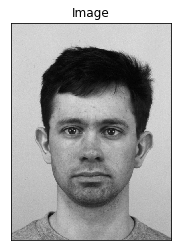

In [2]:
image = cv2.imread('AM04NES.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.xticks([])
plt.yticks([])
plt.show()

## Mean Filter

A 9 x 9 mean filter will be applied to the image.

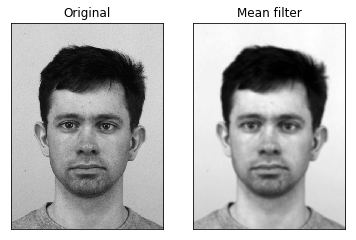

In [3]:
figure_size = 9
new_image = cv2.blur(image,(figure_size, figure_size))

plt.subplot(121), plt.imshow(image, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image, cmap='gray'),plt.title('Mean filter')
plt.xticks([]), plt.yticks([])
plt.show()

Some of the noise has been removed however some detail has been lost.

## Gaussian Filter

A 9 x 9 Gaussian filter (with sigma = 0) will be applied to the image.

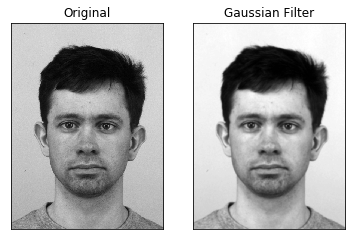

In [4]:
new_image_gauss = cv2.GaussianBlur(image, (figure_size, figure_size),0)

plt.subplot(121), plt.imshow(image, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image_gauss, cmap='gray'),plt.title('Gaussian Filter')
plt.xticks([]), plt.yticks([])
plt.show()

A 9 x 9 Gaussian blur was able to retain more detail than a 9 x 9 mean filter and it was able to remove some noise.

## Median Filter

A 9 x 9 median filter will be applied to the original image.

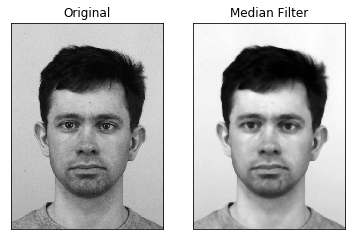

In [5]:
new_image = cv2.medianBlur(image, figure_size)

plt.subplot(121), plt.imshow(image, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image, cmap='gray'),plt.title('Median Filter')
plt.xticks([]), plt.yticks([])
plt.show()

A 9 x 9 median filter was able to remove some of the salt and pepper noise while retaining more detail than the 9 x 9 mean filter.

## Conservative Smoothing

First a function that can apply a conservative smoothing filter will be defined.

In [6]:
def conservative_smoothing_gray(data, filter_size):
    temp = []
    indexer = filter_size // 2
    new_image = data.copy()
    nrow = len(data)
    ncol = len(data[0])
    for i in range(nrow):
        for j in range(ncol):
            for k in range(i-indexer,i+indexer+1):
                for m in range(j-indexer,j+indexer+1):
                    if ((k >=0) and (k <= (nrow-1))) and ((m >= 0) and (m <= (ncol-1))):
                        temp.append(data[k,m])
            temp.remove(data[i,j])
            max_value = max(temp)
            min_value = min(temp)
            if data[i,j] > max_value:
                new_image[i,j] = max_value
            elif data[i,j] < min_value:
                new_image[i,j] = min_value
            temp =[]
    return new_image.copy()

Then a 9 x 9 conservative smoothing filter will be applied to the original image. 

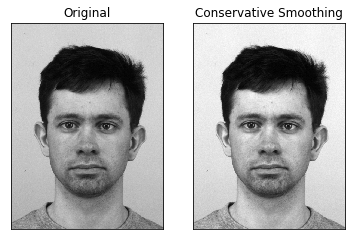

In [7]:
new_image = conservative_smoothing_gray(image,5)

plt.subplot(121), plt.imshow(image, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image, cmap='gray'),plt.title('Conservative Smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

The conservative smoothing filter was able to retain more detail than the median filter however it was not able to remove as much salt-and-pepper noise.

## Laplacian

First the Laplacian of the image will be determined. Then the edges will be enhanced by adding the Laplacian to the original image.

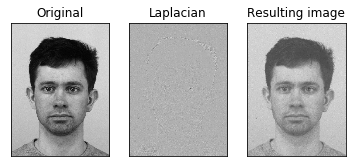

In [8]:
new_image = cv2.Laplacian(image,cv2.CV_64F)

plt.subplot(131), plt.imshow(image, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(new_image, cmap='gray'),plt.title('Laplacian')
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(image + new_image, cmap='gray'),plt.title('Resulting image')
plt.xticks([]), plt.yticks([])
plt.show()

While the edges may have been enhanced, some of the noise was also enhanced.

## Frequency Filter

A low pass filter will be implemented. A high pass filter can be implemented in a similar fashion.

The discret fourier transform will first be applied to the image. The fourier representation of the image will be shown.

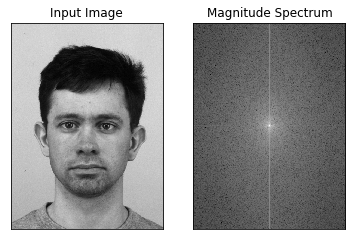

In [9]:
dft = cv2.dft(np.float32(image),flags = cv2.DFT_COMPLEX_OUTPUT)
# shift the zero-frequncy component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)
# save image of the image in the fourier domain.
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

# plot both images
plt.subplot(121),plt.imshow(image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

A low pass filter will be applied and then finally the inverse discrete fourier transform will be applied to get the resulting image.

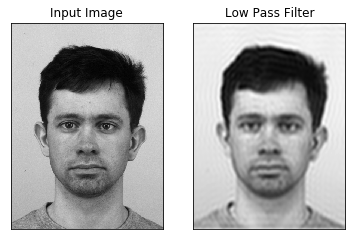

In [10]:
rows, cols = image.shape
crow,ccol = rows//2 , cols//2

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Low Pass Filter'), plt.xticks([]), plt.yticks([])
plt.show()

A decent amount of detail was lost however some of the speckle noise was removed.

## Crimmins Speckle Removal

First a function that applies the Crimmins complementary culling algorithm will be defined.

In [11]:
def crimmins(data):
    new_image = data.copy()
    nrow = len(data)
    ncol = len(data[0])
    
    # Dark pixel adjustment
    
    # First Step
    # N-S
    for i in range(1, nrow):
        for j in range(ncol):
            if data[i-1,j] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if data[i,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow):
        for j in range(1, ncol):
            if data[i-1,j-1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    #NE-SW
    for i in range(1, nrow):
        for j in range(ncol-1):
            if data[i-1,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i-1,j] > data[i,j]) and (data[i,j] <= data[i+1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] > data[i,j]) and (data[i,j] <= data[i,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j-1] > data[i,j]) and (data[i,j] <= data[i+1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j+1] > data[i,j]) and (data[i,j] <= data[i+1,j-1]):
                new_image[i,j] += 1
    data = new_image
    #Third Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i+1,j] > data[i,j]) and (data[i,j] <= data[i-1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j-1] > data[i,j]) and (data[i,j] <= data[i,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j+1] > data[i,j]) and (data[i,j] <= data[i-1,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j-1] > data[i,j]) and (data[i,j] <= data[i-1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    
    # Light pixel adjustment
    
    # First Step
    # N-S
    for i in range(1,nrow):
        for j in range(ncol):
            if (data[i-1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if (data[i,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow):
        for j in range(1,ncol):
            if (data[i-1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow):
        for j in range(ncol-1):
            if (data[i-1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i-1,j] < data[i,j]) and (data[i,j] >= data[i+1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] < data[i,j]) and (data[i,j] >= data[i,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j-1] < data[i,j]) and (data[i,j] >= data[i+1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j+1] < data[i,j]) and (data[i,j] >= data[i+1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # Third Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i+1,j] < data[i,j]) and (data[i,j] >= data[i-1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol-1):
            if (data[i,j-1] < data[i,j]) and (data[i,j] >= data[i,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j+1] < data[i,j]) and (data[i,j] >= data[i-1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j-1] < data[i,j]) and (data[i,j] >= data[i-1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    return new_image.copy()

The results of one iteration of the crimmins complementary culling algorithm will be shown.

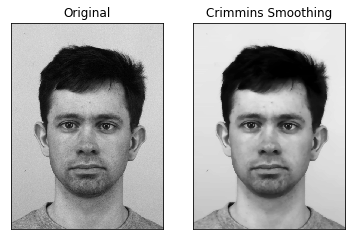

In [12]:
new_image = crimmins(image)

plt.subplot(121), plt.imshow(image, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image, cmap='gray'),plt.title('Crimmins Smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

Some of the speckle noise was removed however some of the edges were blurred.

## Unsharp Filter

The Unsharp filter can be used to enhance the edges of an image. The ImageFilter.Unsharpmask function from the PIL package applys an unsharp filter to an image (the image first needs to be converted to a PIL Image object.) The ImageFilter.Unsharpmask function has three parameters. The 'radius' parameter specifies how many neighboring pixels around edges get affected. The 'percentage' parameter specifies how much darker or lighter the edges become. The third parameter 'threshold' defines how far apart adjacent tonal values have to be before the filter does anything.

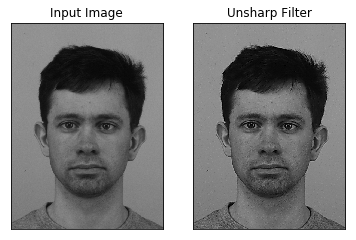

In [13]:
image = Image.fromarray(image.astype('uint8'))
new_image = image.filter(ImageFilter.UnsharpMask(radius=2, percent=150))

plt.subplot(121),plt.imshow(image, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(new_image, cmap = 'gray')
plt.title('Unsharp Filter'), plt.xticks([]), plt.yticks([])
plt.show()

While the edges of the image were enhanced, some of the noise was also enhanced.

## Conclusion

There is always a trade off between removing noise and preserving the edges of an image.